# Luenberger Observer: Estimating State in a Mechanical System

In this notebook, we implement a Luenberger observer for a simple physical system: a cart moving along a rail. 
We demonstrate step-by-step how to model the system, simulate it, design the observer, and evaluate the results.


## System Description

We consider a **cart of mass m** moving along a frictionless track. A motor applies force `u(t)` to the cart. 

We can **measure only its position**, but we want to estimate both **position** and **velocity** in real time.

We model the cart's motion using Newton's second law:

$
m \ddot{x}(t) = u(t)
$

Let the state vector be:

$
x = \begin{bmatrix} x \\ \dot{x} \end{bmatrix}
$

We will design a Luenberger observer to estimate the full state from position measurements only.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import place_poles


## System Model and Discretization

The continuous-time dynamics of the cart can be written in state-space form as:

$
\dot{x} = \begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix} x + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} u
\quad,\quad
y = \begin{bmatrix} 1 & 0 \end{bmatrix} x
$

We discretize this model using Euler method with time step $ \Delta t $.


In [6]:
# Parameters
m = 1.0          # mass (kg)
dt = 0.1         # time step
A = np.array([[1, dt],
              [0, 1]])
B = np.array([[0],
              [dt / m]])
C = np.array([[1, 0]])


## Observer Design Problem

We can only measure the position of the cart (not its velocity). We want to estimate both using a Luenberger observer:

$
\hat{x}_{k+1} = A \hat{x}_k + B u_k + L(y_k - C \hat{x}_k)
$

We must choose a gain matrix $ L $ such that the estimation error $ e_k = x_k - \hat{x}_k $ converges to zero.


In [29]:
# Desired observer poles (fast but not too aggressive)
desired_poles = [NaN, NaN]

# Compute observer gain using dual system (transpose)
place_result = place_poles(A.T, C.T, desired_poles)
L = place_result.gain_matrix.T
print("Observer gain L:\n", L)


Observer gain L:
 [[0.9]
 [1.8]]


## Simulation: True System vs Observer

We now simulate both the true system and the observer for a sequence of control inputs.
We'll apply a step force to the cart and observe how the state estimate converges.


In [30]:
x = np.zeros((2, n_steps))
x_hat = np.zeros((2, n_steps))
y = np.zeros(n_steps)
y_hat = np.zeros(n_steps)

# Initial condition
x[:, 0] = np.array([0.0, 0.0])
x_hat[:, 0] = np.array([2.0, -1.0])

# Simulation loop (corrected)
for k in range(n_steps - 1):
    # True system
    x[:, k+1] = NaN
    y[k] = NaN

    # Observer
    y_hat[k] = NaN
    correction = NaN  # ensure 2D shape
    x_hat[:, k+1] = NaN

# Final output values
y[-1] = NaN
y_hat[-1] = NaN

/var/folders/66/mftm_5nx44b3wqwbrl919gwc0000gn/T/ipykernel_49258/1367153552.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[k] = float(C @ x[:, k])
/var/folders/66/mftm_5nx44b3wqwbrl919gwc0000gn/T/ipykernel_49258/1367153552.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_hat[k] = float(C @ x_hat[:, k])
/var/folders/66/mftm_5nx44b3wqwbrl919gwc0000gn/T/ipykernel_49258/1367153552.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[-1] = float(C @ x[:,

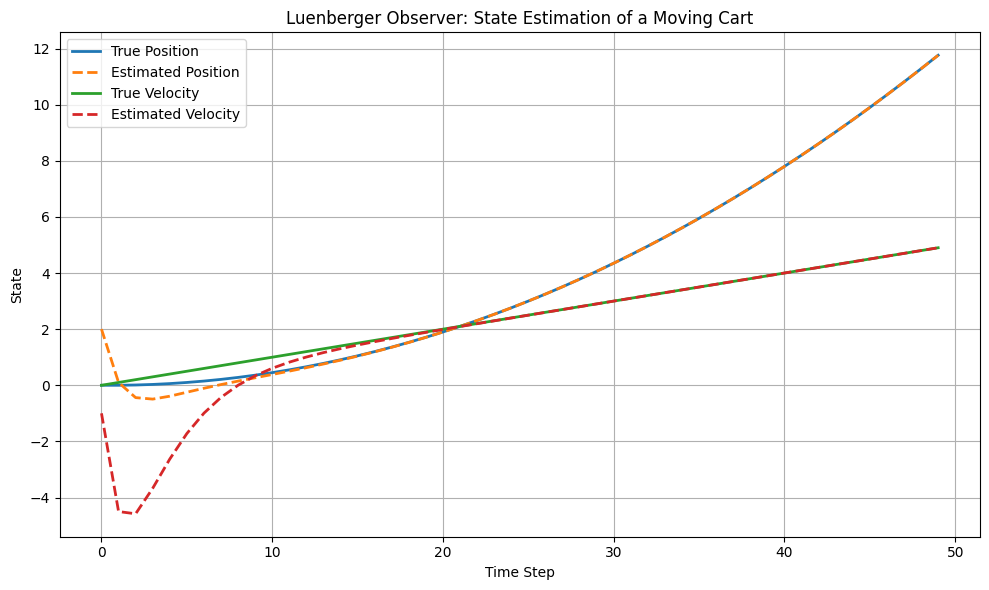

In [31]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x[0], label='True Position', linewidth=2)
plt.plot(x_hat[0], '--', label='Estimated Position', linewidth=2)
plt.plot(x[1], label='True Velocity', linewidth=2)
plt.plot(x_hat[1], '--', label='Estimated Velocity', linewidth=2)
plt.xlabel("Time Step")
plt.ylabel("State")
plt.title("Luenberger Observer: State Estimation of a Moving Cart")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()